## Problem 1
(Sampling, 10pts) Before we do any experiment in this homework, make sure that you use gray scale normalized image for your experiment, i.e., your image intensity should range [0,1]. You may use built-in functions for **image normalization**. Implement your own function to downsample an image into half size (for x and y directions) by sampling every other pixel. Perform downsampling twice on ‘lena.png’. 

Compare the downsampled images with the original in the same actual size (pixel size for low resolution images should be bigger.) 

How do they look? Now, perform upsampling of the image by inserting an empty pixel between every and each pixel. Run it twice to get it back to the original size. How are the upsampled images looking? Write your observation in the report.



### Answer

1. Why do we need gray scale instead of the RGB image?

Because Many image processing and computer vision algorithms (Canny, Hough, Sobel) use grayscale images rather than color images. These tasks involve edge detection and color information is not useful, hence grayscale is just fine. Also grayscale processing is at least three times faster than that of color image processing. This is because grayscale image has only one color channel as opposed to three in a color image.

2. Why do we need to normalize the images beforehand?

Because (1) First, if data is not normalized, features with larger numerical values dominate features with smaller numerical values and consequently we will not get contributions from features with smaller values. (2) A lot of machine learning algorithms, such as deep learning will need the images to be normalized so that computationaly it is easier.

There are different normalization methods:
$norm_i = (p_i - p_{min})/(p_{max} - p_{min})$

In [12]:
!mkdir computer_vision

mkdir: cannot create directory ‘computer_vision’: File exists


In [13]:
!ls

computer_vision  sample_data


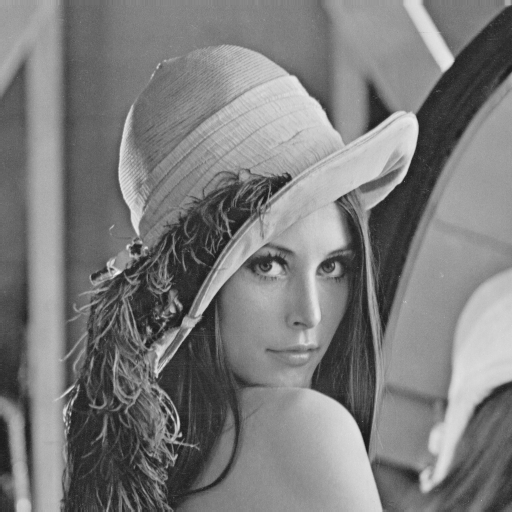

(512, 512)


In [65]:

import cv2
from google.colab.patches import cv2_imshow


rgb_image = cv2.imread('computer_vision/Lena.png')
# convert to gray scale
image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image )
print(image.shape)

In [0]:
def normalize(I, min_v=None, max_v=None):
  if not min_v:
    min_v = np.min(I)
  if not max_v:
    max_v = np.max(I)
  return (I-min_v)/(max_v-min_v)

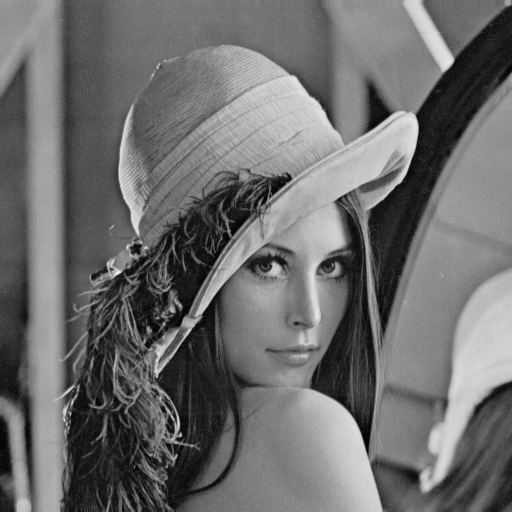

In [68]:
# normalize the image
image = normalize(image, 0, 255)
cv2_imshow(image*255)

In [0]:
import numpy as np
def downsample(image, ratio=0.5):
  img = np.asarray(image)
  ratio = 0.5
  assert ratio < 1 and ratio > 0
  # numpy array has size and shape
  nrows, ncols = (int(img.shape[0]*ratio), int(img.shape[1]*ratio))
  dimg = np.zeros((nrows, ncols))
  times = 1.0/ratio
  for r in range(nrows):
    for c in range(ncols):    
      dimg[r][c] = img[int(r*times)][int(c*times)]
  return dimg
  

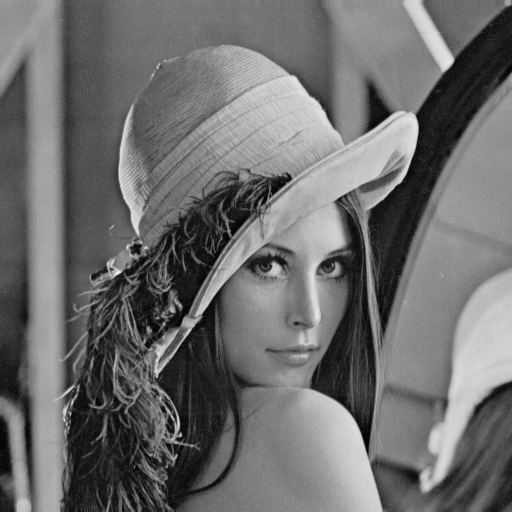

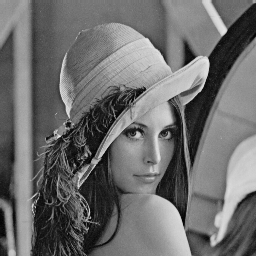

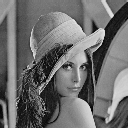

(128, 128)


In [70]:
half_img = downsample(image)
quard_img = downsample(half_img)

cv2_imshow(image*255), cv2_imshow(half_img*255), cv2_imshow(quard_img*255)
print(quard_img.shape)

In [0]:
def upsample(image, times=2):
  img = np.asarray(image)
  assert times > 1
  # numpy array has size and shape
  nrows, ncols = (int(img.shape[0]*times), int(img.shape[1]*times))
  dimg = np.zeros((nrows, ncols))
  ratio = 1.0/times
  for r in range(nrows):
    for c in range(ncols):    
      dimg[r][c] = img[int(r*ratio)][int(c*ratio)]
  return dimg

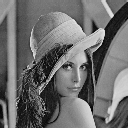

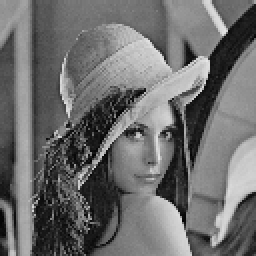

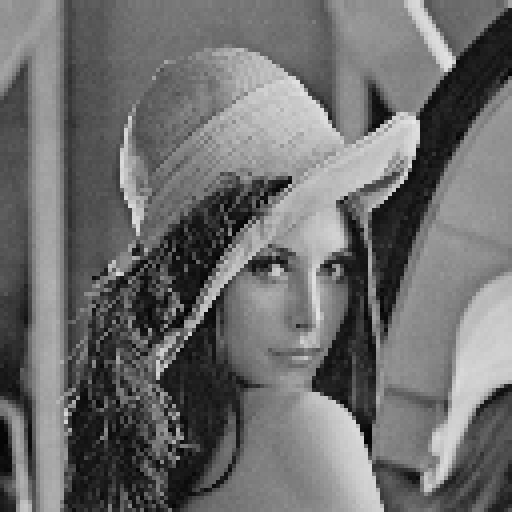

(512, 512)


In [71]:
double_img = upsample(quard_img)
quardt_img = upsample(double_img)

cv2_imshow(quard_img*255), cv2_imshow(double_img*255), cv2_imshow(quardt_img*255)
print(quardt_img.shape)

In [0]:
#@title Fun downsampling
def downsample(image, ratio=0.5):
  img = np.asarray(image)
  ratio = 0.5
  assert ratio < 1 and ratio > 0
  # numpy array has size and shape
  nrows, ncols = (int(img.shape[0]*ratio), int(img.shape[1]*ratio))
  #dimg = np.zeros((nrows, ncols))
  times = 1.0/ratio
  for r in range(nrows):
    for c in range(ncols):    
      img[r][c] = img[int(r*times)][int(c*times)]
  return img
  

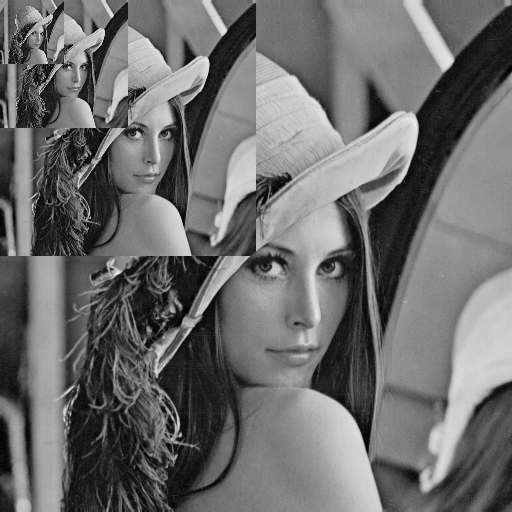

In [73]:
img = image.copy()
for i in range(3):
  img = downsample(img)
cv2_imshow(img*255)

### Observation

As we see, when we are downsampling images, we are throwing away data blindly which lead to the unrecoverable information loss, as we see in the upsampling, we get a image of the original size but severely blurred out and looks quite shape in the change of color. The solution is to apply filtering on top of these recovered image to appear more smoothy. 

## Problem 2
(Gaussian smoothing, 30pts) Implement a function that takes in an image $I$, kernel size $k$ and scaling parameter $s$ (i.e., $σ$) and outputs its smoothed version after Gaussian smoothing, i.e., $I smooth = myGaussianSmoothing(I, k, s)$. Test it on the given image 'lena.png’. 

Change the kernel size to k = {3, 5, 7, 11, 51} with fixed s = 1. What changes in the result do you see? Now, change the s = {0.1, 1, 2, 3, 5} with fixed kernel size k = 11. How is the result changing? 

Explain what you did and a brief report on your observation.


### Answer
We need to first implement the convolution operator, and then apply the gaussian kernel. 

The commonly used convolution in deep learning network is actually a correlation. 
#### One-dimensional Correlation
$(a*ker)[i] = \sum_{m=0}^{2r}ker[m]\times a[i+m]$ 

* Valid: Because kernel has size $k$, if we let $i \in [0, n-1]$, when $i=0$, $i+m \in [0, n-1+r]$. If we do not pad, then the size will be $n-k+1$. 

* Same: To keep the size to be the same, a[0] needs to map to the middle value in the kernel. This means at the left and right size, we both need to pad $(k-1)//2$.  With the extra padding, now our size become $n$.
* Full: in this mode, instead of padding $(k-1)//2$, we pad $k-1$ on each size, now, our size become $n+2k-2-k+1=n+k-1$.

#### One-dimensional Convolution
Compared with correlation, we just need to mirror kernel vector to get the convolution; rotating the vector by 180 degree, which is reversed. 

In [0]:
def correlate(a, kernel):
  n = len(a)
  k = len(kernel)
  out = [0] * (n-k+1)
  for i in range(n-k+1):
    total = 0
    for m in range(k):
      total += kernel[m] * a[i+m]
    out[i] = total
  return out
  

To keep the image to have the same size, we have to do padding. 

In [75]:
# to keep the image to 
c1 = np.correlate([1,2,3],[0,1,0.5], 'full')
c2 = np.correlate([1,2,3],[0,1,0.5], 'same')
c3 = np.correlate([1,2,3],[0,1,0.5], 'valid')
print(c1, c2, c3)
kernel = [0, 1, 0.5] # mirrored list(reversed([1, 2, 3]))
print(kernel)
a = [1, 2, 3]

[0.5 2.  3.5 3.  0. ] [2.  3.5 3. ] [3.5]
[0, 1, 0.5]


In [24]:
print(correlate(a, kernel))
print(correlate([0]*((len(kernel)-1)//2) + a+ [0]*((len(kernel)-1)//2), kernel))
print(correlate([0]*((len(kernel)-1)) + a+ [0]*((len(kernel)-1)), kernel))

[3.5]
[2.0, 3.5, 3.0]
[0.5, 2.0, 3.5, 3.0, 0.0]


In [25]:
c1 = np.convolve([1,2,3],[0,1,0.5], 'full')
c2 = np.convolve([1,2,3],[0,1,0.5], 'same')
c3 = np.convolve([1,2,3],[0,1,0.5], 'valid')
print(c1, c2, c3)

[0.  1.  2.5 4.  1.5] [1.  2.5 4. ] [2.5]


In [26]:
mirror_kernel = kernel[::-1]
  
print(correlate(a, mirror_kernel))
print(correlate([0]*((len(mirror_kernel)-1)//2) + a+ [0]*((len(mirror_kernel)-1)//2), mirror_kernel))
print(correlate([0]*((len(mirror_kernel)-1)) + a+ [0]*((len(mirror_kernel)-1)), mirror_kernel))

[2.5]
[1.0, 2.5, 4.0]
[0.0, 1.0, 2.5, 4.0, 1.5]


In [0]:
def conv2d(img, kernel, mode='same'):
  assert kernel.shape[0] == kernel.shape[1] and kernel.shape[0] % 2 == 1
  k = kernel.shape[0]
  pad_shape = ((0, 0), (0, 0)) # left, right, up down
  if mode == 'full':
    pad_size = k-1
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
  elif mode == 'same':
    pad_size = (k-1) // 2
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
    
  padded_array = np.pad(img, pad_shape, 'constant')
  out_shape = (padded_array.shape[0]-kernel.shape[0]+1,  padded_array.shape[1]-kernel.shape[1]+1)
  output_array = np.zeros(out_shape)
  
  for i in range(out_shape[0]):
    for j in range(out_shape[1]):
      temp_array = padded_array[i: i+k, j: j+k]
      output_array[i, j] = np.sum(temp_array*kernel)
  return output_array


### Gaussian Distribution
One dimensional Gaussian Function
![alt text](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/gauss1.gif)

Two dimensional gaussian function

An isotropic (circularly symmetric) Gaussian:
![alt text](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/gauss2.gif)

$G(x, y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$

$\sigma$ is the standard deviation, and from the gaussian distribution, we shall see the large the deviation the farther away that the smoothing is.


Gaussian smoothing is a low-pass filter, which means it wont cause high-frequency artifacts

### Gaussian Kernels
To convert a gaussian distribution to a discrete guassian kernel, we need to consider: 

1. Since the image is stored as a collection of discrete pixels we need to produce a discrete approximation to the Gaussian function before we can perform the convolution.

2. In theory, the Gaussian distribution is non-zero everywhere, which would require an infinitely large convolution kernel, but in practice $+/- 3\sigma$ covers 99\% of the area. Thus we can truncate the kernel at this point. 

3. Therefore, the continuous values in $[-3\sigma, +3\sigma]$ need to be discreted onto a kernel. How? Sampling?

### Gaussian Kernel Implementation

There are two ways to discrete a gaussian distribution to a guassian kernel:

1. Sampled Gaussian kernel: sample the continuous Gaussian, yielding the sampled Gaussian kernel. However, this discrete function does not have the discrete analogs of the properties of the continuous function, and can lead to undesired effects, as described in the article scale space implementation. 

2. Discrete Gaussian kernel: This is the discrete analog of the continuous Gaussian in that it is the solution to the discrete diffusion equation (discrete space, continuous time), just as the continuous Gaussian is the solution to the continuous diffusion equation.

In my implementation, I use the sampling method which is simpler to implement.
 


### Two properties
#### Factoring of Convolution

if $a_2[i, j] = a_1[i] \times a_2[j]$, then we say $a_2$ is separable, and it is good because it allows factoring. In our case, the gaussian kernel is, we use $ker[i,j] = ker[i] \times ker[j]$. (Put an image here)

$(a*ker)[i, j]=\sum_{i'=0}^{2r}\sum_{j'=0}^{2r}ker[i', j']\times a[i+i'][j+j']$

$=\sum_{i'=0}^{2r}\sum_{j'=0}^{2r}ker[i']ker[j']\times a[i+i'][j+j'] = \sum_{i'=0}^{2r}ker[i'](\sum_{j'=0}^{2r}ker[j']\times a[i+i'][j+j'])$.
This is to say, we can first convolve our input 2-d $a$ with a 1-D kernel on the $col$ dimensional, that is we convolve each row of $a$ with one-dimensional vector with $a_{inter}$, then we convolve each col of $a_{inter}$ with the 1-D kernel. If $a$ has size $R\times C$, the cost will be $2 R\times C \times k$ instead of $k^2\times R\times C$.

#### Cascaded Gaussians
The shape of the kernel remains the same, irrespective of the s. When we convolve two Gaussian kernels  weget a new wider Gaussian with a variance s2 which is the sum of the variances of the constituting Gaussians:
$g(\sigma_1^2)*g(\sigma_2^2) = g(\sigma_1^2+\sigma_2^2)$. Because if ${(k_1+k_2)}^2\geq k_1^2 + k_2^2$. This further saves us more time. This means, instead of using a large kernel, we replace it with multiple smaller kernels.

Both factoring and cascading can be seen to be applied in deep neural network head, such as the separable convolution and the use of multiple smaller kernels, usuing with $3\times 3$ and $5\times 5$.

### Implementation

Gaussian filter areseparable:
1. First convolve each row with a 1D filter
2. Then convolve each column with a 1D filter.

In [0]:
# define a gaussian function
def Gaussian(x, y, sigma):
    return np.exp((-(x**2+y**2)/(2*sigma**2))) / (2*np.pi*sigma**2)

In [30]:
print(Gaussian(0, 0, 1))

0.15915494309189535


In [0]:
def GaussianKernel(k, s):
  kernel = np.zeros((k, k))
  mid = (k - 1)//2
  sum = 0
  for i in range(k):
    for j in range(k):
      kernel[i, j] = Gaussian(i-mid, j-mid, s)
      sum += kernel[i, j]
  # normalize
  kernel = kernel/sum
  return kernel

In [0]:
def myGaussianSmoothing(I, k, s): 
  '''
  One pass
  '''
  kernel = GaussianKernel(k, s)
  #print(kernel)
  return conv2d(I, kernel)

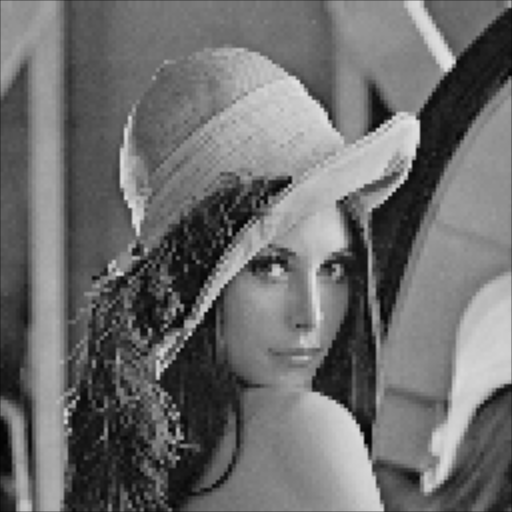

In [78]:
simg = myGaussianSmoothing(quardt_img, 3, 1)
cv2_imshow(simg*255)

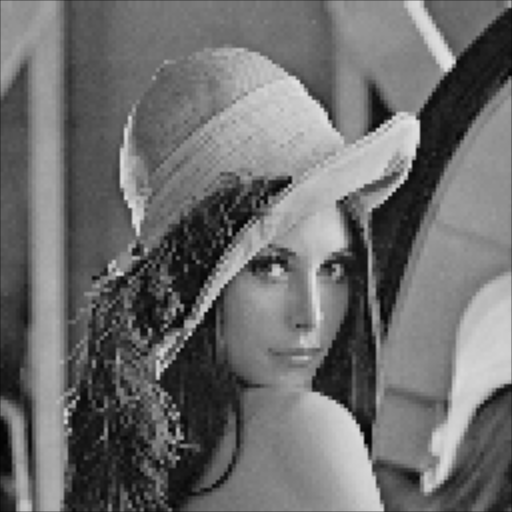

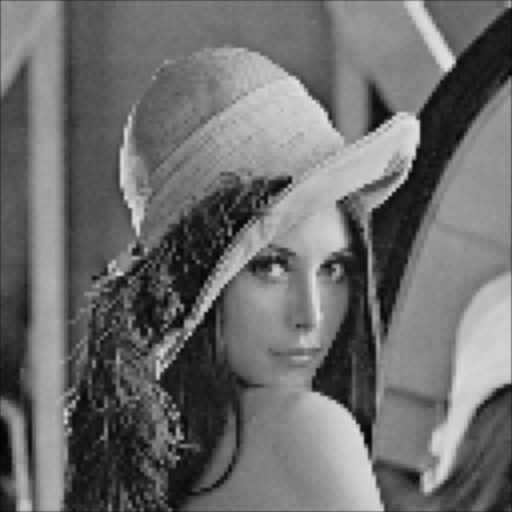

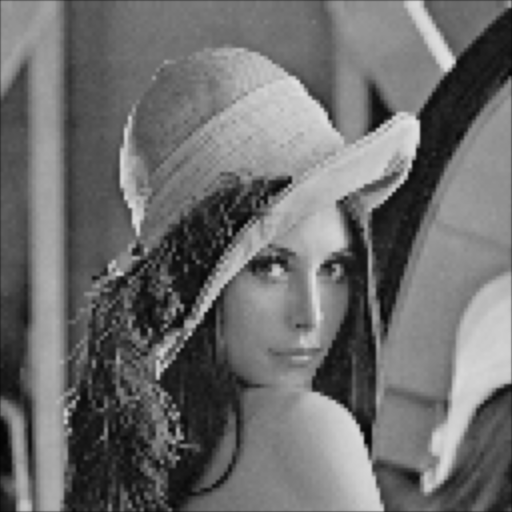

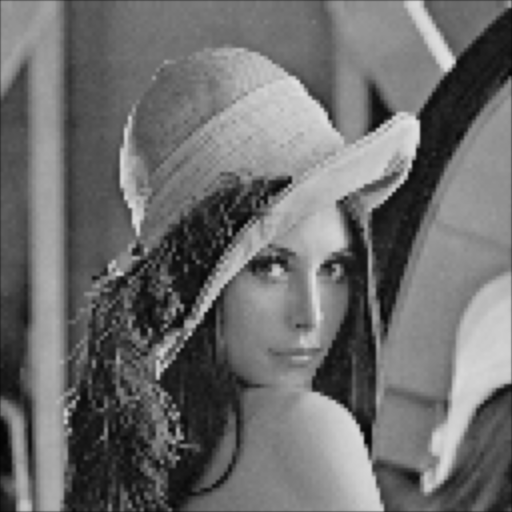

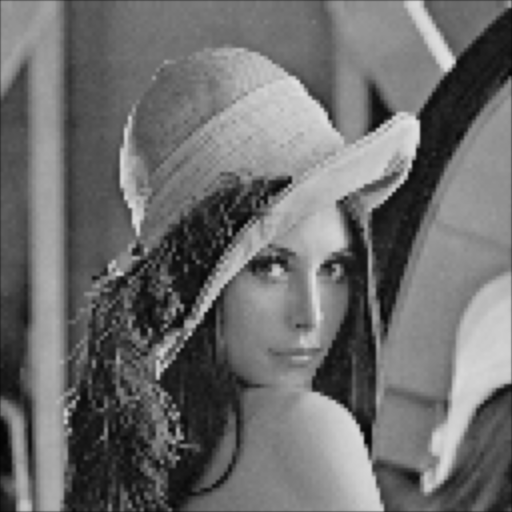

In [79]:
# check effect of kernel
for k in [3, 5, 7, 11, 51]:
  simg = myGaussianSmoothing(quardt_img, k, 1)
  cv2_imshow(simg*255)

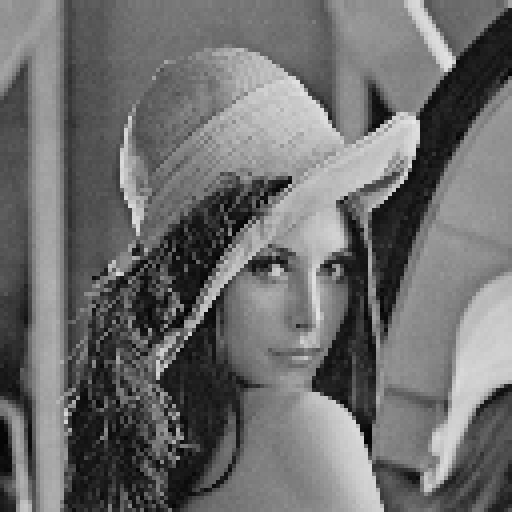

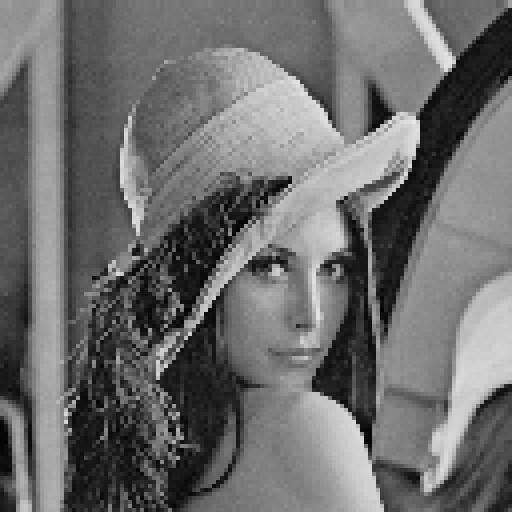

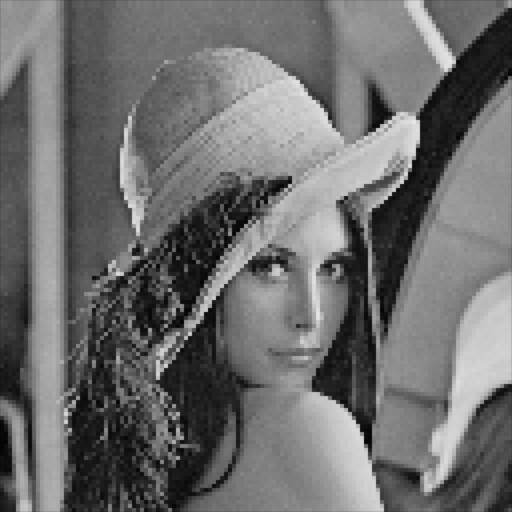

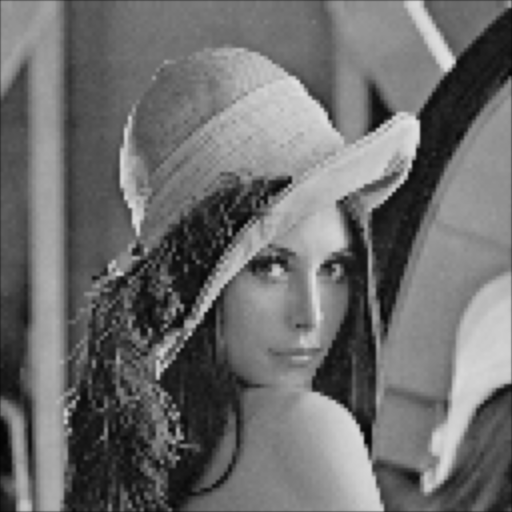

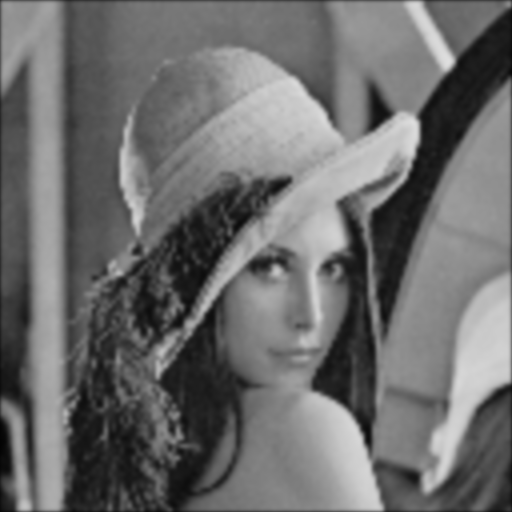

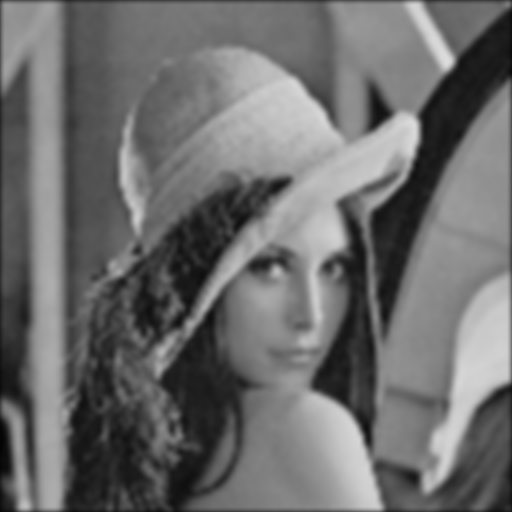

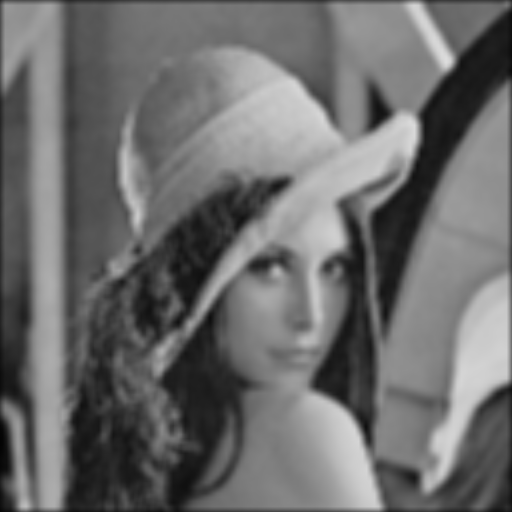

In [80]:
# check effect of sigma
for s in [0.1, 0.3, 0.5, 1, 2, 3, 5]:
  simg = myGaussianSmoothing(quardt_img, 11, s)
  cv2_imshow(simg*255)

### Observation

The effects of the two factors $k$ and $\sigma$ depends on how to implement the gaussian kernel. In our sampled gaussian kernel, we would observe:
1. $k$ will only affect the sampling frequency range of the gaussian function, the larger, the farther the sampling to be. But because $99\%$ of the area are within $3\sigma$, thus, in all, the affect of the kernel size is small.

2. The degree of smoothing is determined by the standard deviation $\sigma$ of the Gaussian. (Larger standard deviation Gaussians, of course, require larger convolution kernels in order to be accurately represented.)


#### Gaussian smoothing VS mean filtering
The effect of Gaussian smoothing is to blur an image, in a similar fashion to the mean filter. 

The Gaussian outputs a `weighted average' of each pixel's neighborhood, with the average weighted more towards the value of the central pixels. This is in contrast to the mean filter's uniformly weighted average. Because of this, a Gaussian provides gentler smoothing and preserves edges better than a similarly sized mean filter. 

### Problem 3
(Image filtering, 20pts) Let’s solve the problem that occurred from sampling. Everytime after performing upsampling, perform Gaussian smoothing with k = 11 and σ = 1. Did it get better? How about we perform median filtering? Implement your own median filter and apply it on the same upsampled data. Did it improve the result? Which filtering is better? Discuss your observation in the report.


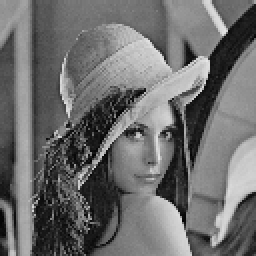

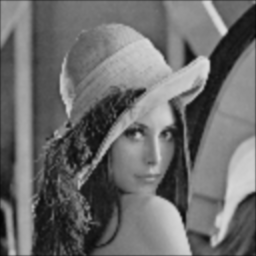

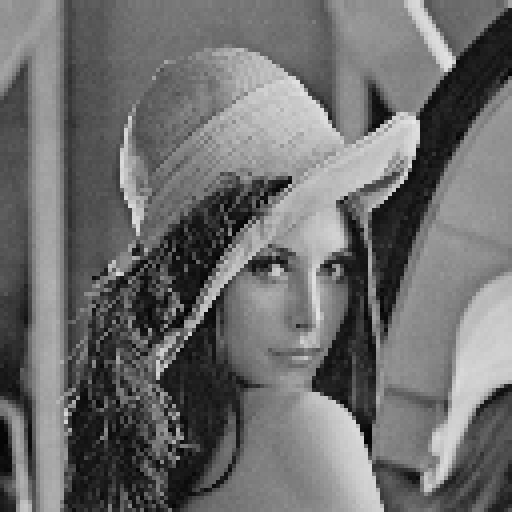

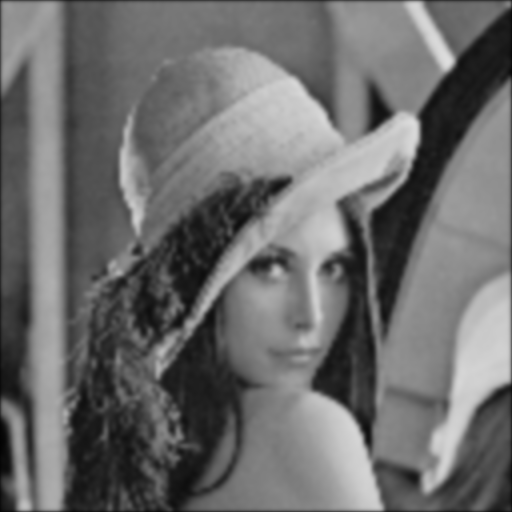

(None, None)

In [81]:
# Perform gaussian smoothing after each upsampling
double_img = upsample(quard_img)
double_img_smooth = myGaussianSmoothing(double_img, 11, 1)
quardt_img = upsample(double_img)
quardt_img_smooth = myGaussianSmoothing(upsample(double_img_smooth), 11, 1)

cv2_imshow(double_img*255), cv2_imshow(double_img_smooth*255)
cv2_imshow(quardt_img*255), cv2_imshow(quardt_img_smooth*255)

#### Observation
We can see that with the gaussian smoothing after each upsampling does increase the visual quality of the image, where the high-frequency artifacts are taken away.

In [0]:
# use mean filtering
def myMedianSmoothing(img, k, mode='same'):
  assert k % 2 == 1
  pad_shape = ((0, 0), (0, 0)) # left, right, up down
  if mode == 'full':
    pad_size = k-1
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
  elif mode == 'same':
    pad_size = (k-1) // 2
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
    
  padded_array = np.pad(img, pad_shape, 'constant')
  out_shape = (padded_array.shape[0]-kernel.shape[0]+1,  padded_array.shape[1]-kernel.shape[1]+1)
  output_array = np.zeros(out_shape)
  
  for i in range(out_shape[0]):
    for j in range(out_shape[1]):
      
      temp_array = padded_array[i: i+k, j: j+k]
      output_array[i, j] = np.median(temp_array)
  return output_array

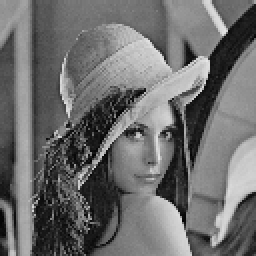

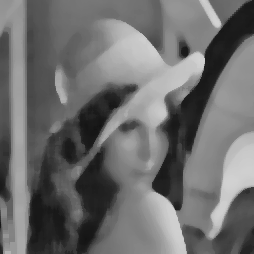

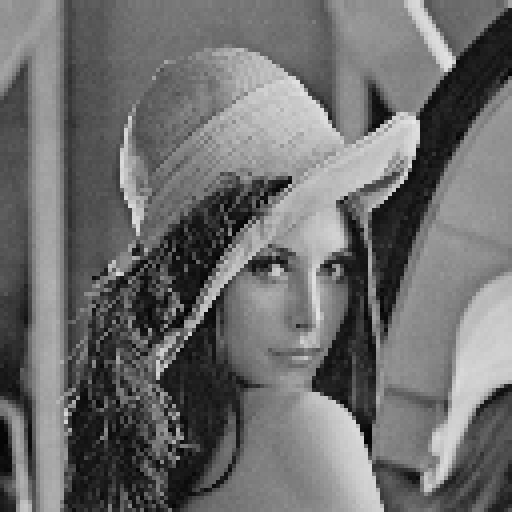

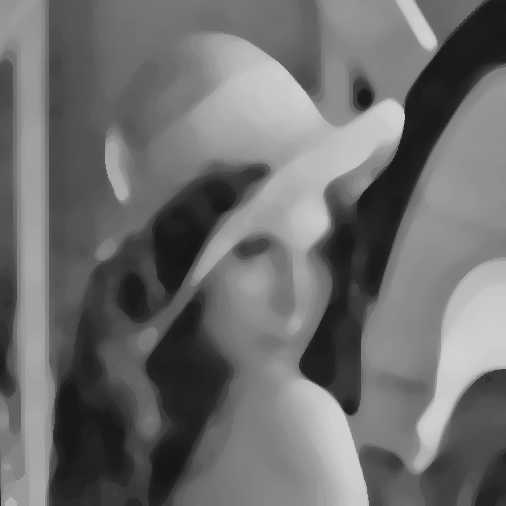

(506, 506)


In [82]:
# Perform median smoothing after each upsampling
double_img = upsample(quard_img)
double_img_smooth = myMedianSmoothing(double_img, 11,'valid')
quardt_img = upsample(double_img)
quardt_img_smooth = myMedianSmoothing(upsample(double_img_smooth), 11,'valid')

cv2_imshow(double_img*255), cv2_imshow(double_img_smooth*255)
cv2_imshow(quardt_img*255), cv2_imshow(quardt_img_smooth*255)
print(quardt_img_smooth.shape)

### Obeservation

Median filtering heavily bluring the image. When applying it multiple times, it gets very bad.

### Problem 4
(Noise, 20pts) On the original ‘lena.png’ image, let’s add some Gaussian noise ∼ N(0,0.1) at each pixel, i.e., I noisy(x,y) = I(x,y)+r where r ∼ N(0,0.1). How is the image looking? Now, let’s perform Gaussian smoothing with any parameter you like that works. Did the result improve? Now, let’s go change the type of noise you added. Before you add it to the original image, set the noise to value 1 everywhere where the noise was > 0.2 and 0 otherwise. Median filter in the previous question probably made you frustrating, but let’s give it one more chance. Apply median filtering and see what you get. Discuss your observation in the report. You do not have to implement something new but it would be doing a few more experiments.


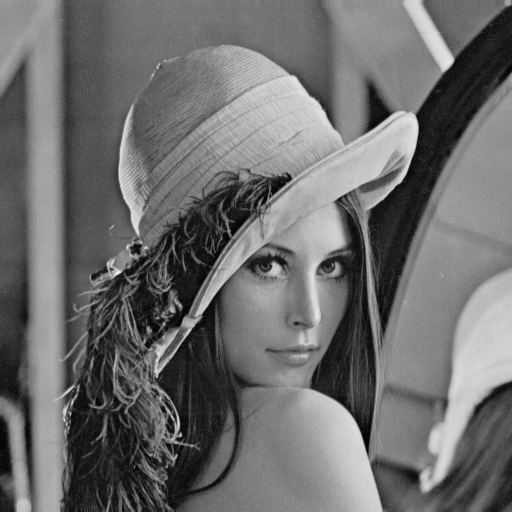

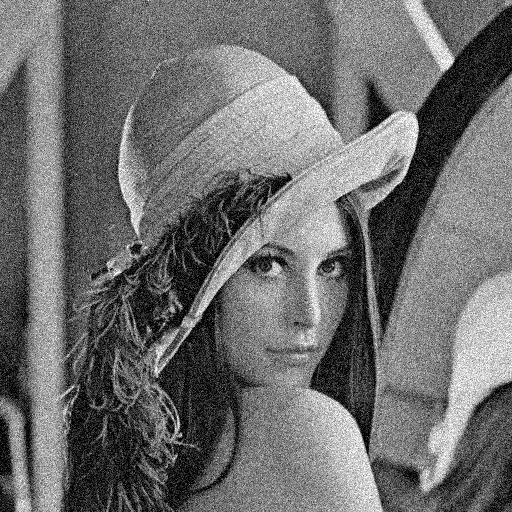

In [84]:
mean, sigma = 0, 0.1
gauss_noise = np.random.normal(mean,sigma,image.shape)
noise_img = image + gauss_noise
cv2_imshow(image*255)
cv2_imshow(noise_img*255)

#### Observation
We can really see how the gaussian noise has blurred the images visually.

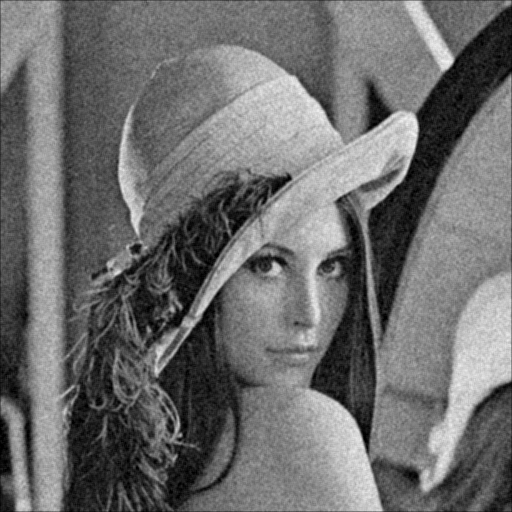

In [85]:
# Let’s perform Gaussian smoothing
smoothed_image = myGaussianSmoothing(noise_img, 3, 10)
cv2_imshow(smoothed_image*255)

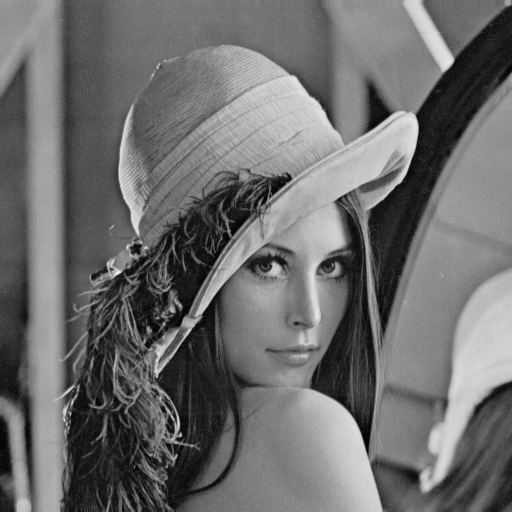

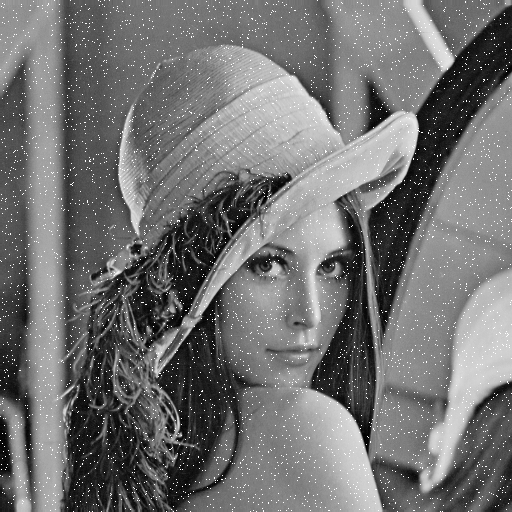

In [86]:
# Before you add it to the original image, set the noise to value 1 everywhere where the noise was > 0.2 and 0 otherwise.
img_noise = np.zeros((image.shape))
for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    img_noise[i,j] = image[i,j]+1 if gauss_noise[i,j] > 0.2 else image[i,j]
cv2_imshow(image*255)    
cv2_imshow(img_noise*255)

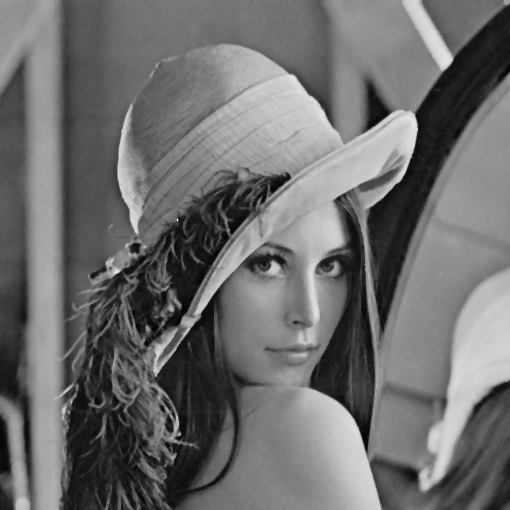

In [87]:
# Apply median filtering
median_smooth_img = myMedianSmoothing(img_noise, 3,'valid')
cv2_imshow(median_smooth_img*255)

#### Observation.
Now, we observe that the median filtering is really good at removing peper and salt noise. Median filtering is non-linear filtering. Median filtering is good at removing noise while at the same time reserve the edges.  It is particulary good at revmoing peper and salt noise. 

### Problem 5
(Sobel filters, 20pts) Implement a Sobel filter that calculates gradient along x and y directions. To visualize our sobel operator, normalize the gradients so that all the values lie between [0,1]. Your function should look like $[mag, ori] = mySobelFilter(I)$ that takes an image I as an input and output edge response (magnitude) and orientation for each pixel. Try visualizing the result in color by using the magnitude to specify the saturation and value of an image and the orientation to specify the hue. We haven’t talked HSV space in the class but can be found at https://en.wikipedia.org/wiki/HSL_and_HSV. Discuss your observation in the report.
 

#### Answer
The gradient of an image is 
\begin{equation}
\Delta f = [\Delta x, \Delta y]
\end{equation}
The gradient magnitude is
\begin{equation}
||\Delta f|| = \sqrt{(\Delta x)^2+(\Delta y)^2}
\end{equation}
And the gradient direction/orientation is given as
\begin{equation}
\theta = \tan^{-1}{(\Delta y/\Delta x)}
\end{equation}

In [0]:
def mySobelFilter(I):
  G_y = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]], dtype=np.float16)
  G_x = np.array([[-1, -2, -1],
                  [0, 0, 0],
                  [1, 2, 1]])

  g_x = conv2d(I, G_x, mode='same')
  g_y = conv2d(I, G_y, mode='same')
  cv2_imshow(normalize(g_x)*255)
  cv2_imshow(normalize(g_y)*255)
  magnitude = np.sqrt(g_x*g_x + g_y*g_y)
  orientation = 1/np.tan(normalize(g_y)/normalize(g_x))
  return magnitude/magnitude.max(), orientation#/orientation.max()

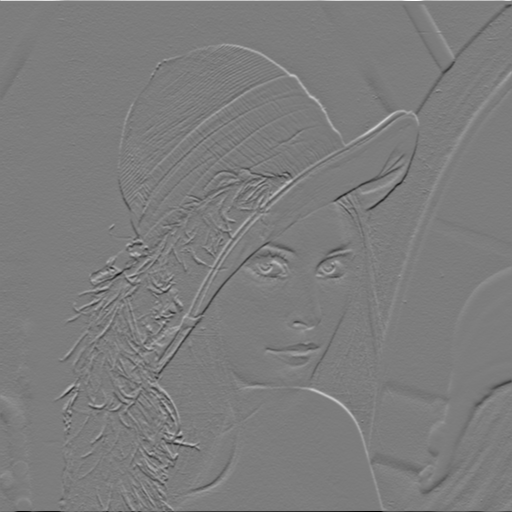

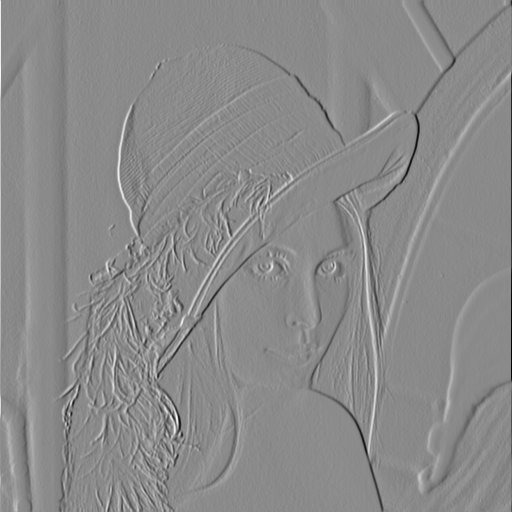

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in tan
  


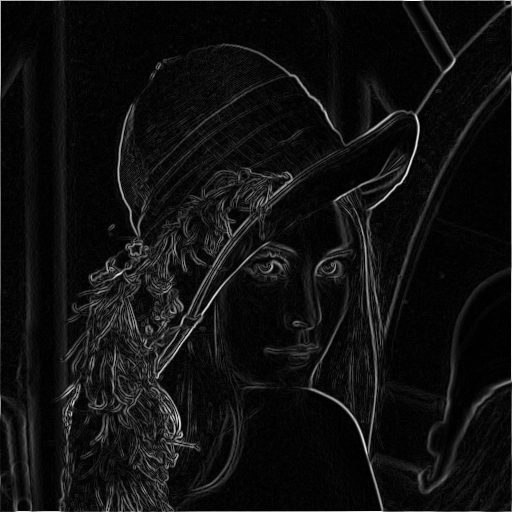

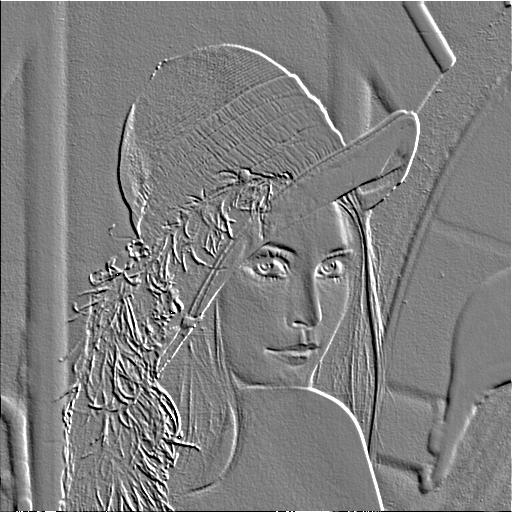

In [117]:
mag, ori = mySobelFilter(image)
cv2_imshow(mag*255)
cv2_imshow(ori*255)

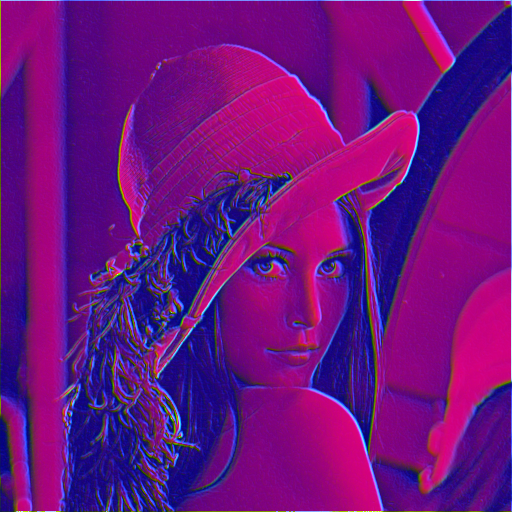

In [130]:
# Try visualizing the result in color by using the magnitude to specify the saturation and value of an image and the orientation to specify the hue.
import cv2
hsv = np.array([ori, mag, image])
hsv = np.transpose(hsv, (1, 2, 0))
#print(hsv.shape)
#rgb_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR )
cv2_imshow(hsv*255)

#### Observation
Sobel Filter should be better applied together with Gaussian filtering. 

We can observe limitation of the sober filter:
* Poor Localization, which means you will see many edges where we actually should have only edge.
* Can miss edges which are neither verticle or horizontal.

This futher leads to the need of Canny Edge Detector


## Reference
1. http://www.cs.cmu.edu/~16385/s17/Slides/4.0_Image_Gradients_and_Gradient_Filtering.pdf
2. http://learn.leighcotnoir.com/artspeak/elements-color/hue-value-saturation/